In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv('data/train.csv')

In [3]:
dataset.tail()

,id,race,date,time,circuit,latitude,longitude,altitude,driver,carNumber,constructor,avgDriverFinish,avgConstructorFinish,lapNumber,lapPosition,pitStop,pitCount,pitTime_ms,lapTime_ms
29995,29996,Azerbaijan Grand Prix,2021-06-06,12:00:00,Baku City Circuit,40.3725,49.85330,-7,"Alonso, Fernando",14,Alpine F1 Team,7.448925,5.303571,39,11,0,2,0.0,106314
29996,29997,Chinese Grand Prix,2016-04-17,06:00:00,Shanghai International Circuit,31.3389,121.22000,5,"Rosberg, Nico",6,Mercedes,6.766990,2.199262,53,1,0,2,0.0,100814
29997,29998,European Grand Prix,2002-06-23,NaN,Nürburgring,50.3356,6.94750,578,"Trulli, Jarno",14,Renault,11.580000,5.199507,40,6,0,0,0.0,95675
29998,29999,United States Grand Prix,2014-11-02,20:00:00,Circuit of the Americas,30.1328,-97.64110,161,"Rosberg, Nico",6,Mercedes,6.766990,2.199262,13,1,0,0,0.0,104406
29999,30000,Italian Grand Prix,1997-09-07,NaN,Autodromo Nazionale di Monza,45.6156,9.28111,162,"Schumacher, Michael",5,Ferrari,4.325879,2.833984,16,7,0,0,0.0,87347


In [4]:
dataset.drop(['id', 'race', 'carNumber'], axis=1, inplace=True)

In [5]:
dataset['time'].fillna('NaN', inplace=True)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset['lapTime_ms'], test_size=0.2, random_state=42)

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("lapTime_ms")
test_labels = test_features.pop("lapTime_ms")

In [8]:
# Define the model
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=10,
    loss_function='RMSE',
    random_seed=42,
    cat_features=['date', 'time', 'circuit', 'driver', 'constructor', 'pitStop']
)

# Train the model
model.fit(
    train_features,
    train_labels,
    eval_set=(test_features, test_labels),
    verbose=100,
    early_stopping_rounds=50
)

0:	learn: 62115.9872192	test: 67046.7440790	best: 67046.7440790 (0)	total: 195ms	remaining: 3m 15s
100:	learn: 23990.1621589	test: 27708.4332793	best: 27708.4332793 (100)	total: 5.91s	remaining: 52.6s
200:	learn: 11681.8101501	test: 13750.5430902	best: 13750.5430902 (200)	total: 11s	remaining: 43.6s
300:	learn: 8011.7334226	test: 11476.6703435	best: 11476.6703435 (300)	total: 16.5s	remaining: 38.3s
400:	learn: 6582.4016937	test: 10593.9320429	best: 10593.9320429 (400)	total: 22.2s	remaining: 33.2s
500:	learn: 5722.3842835	test: 10157.0024246	best: 10157.0024246 (500)	total: 28.1s	remaining: 27.9s
600:	learn: 5210.1817724	test: 9965.8204470	best: 9964.7771527 (597)	total: 33.7s	remaining: 22.4s
700:	learn: 4870.8119225	test: 9848.6793944	best: 9848.6793944 (700)	total: 39.2s	remaining: 16.7s
800:	learn: 4615.7268678	test: 9781.5946570	best: 9781.5946570 (800)	total: 44.9s	remaining: 11.2s
900:	learn: 4398.5527034	test: 9713.4912046	best: 9713.4912046 (900)	total: 50.6s	remaining: 5.56s


In [9]:
test_predictions = model.predict(test_features)

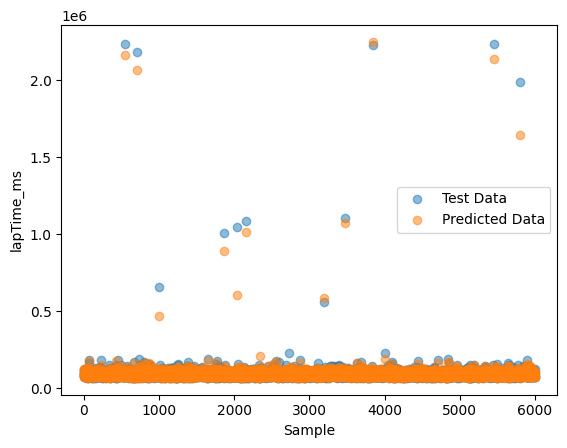

In [10]:
plt.plot(test_labels.to_numpy(), 'o', label='Test Data', alpha=0.5)
plt.plot(test_predictions, 'o', label='Predicted Data', alpha=0.5)
plt.xlabel('Sample')
plt.ylabel('lapTime_ms')
plt.legend()
plt.show()

In [11]:
df_score_raw = pd.read_csv('data/test.csv')

In [12]:
df_score = df_score_raw.drop(['id', 'race', 'carNumber'], axis=1)

In [13]:
df_score['time'].fillna('NaN', inplace=True)

In [14]:
score_predictions = model.predict(df_score)

In [15]:
score_predictions

array([101635.53491985,  71516.04272989,  99892.11246119, ...,
       133075.38069745, 131628.66460789,  86603.76541852])

In [16]:
df_results = pd.DataFrame(df_score_raw['id'], columns=['id'])

In [17]:
df_results['lapTime_ms'] = score_predictions

In [18]:
df_results.tail()

,id,lapTime_ms
20709,50710,84846.526367
20710,50711,78840.156799
20711,50712,133075.380697
20712,50713,131628.664608
20713,50714,86603.765419


In [19]:
df_results.to_csv('results/results.csv', index=False)